In [309]:
import pandas as pd
import numpy as np
import pyarrow.dataset as pads
import pyarrow.csv as pacsv
from SMT_Data_Starter_2025 import readDataSubset
import matplotlib.pyplot as plt
from IPython.display import HTML
import great_tables as gt

In [310]:
# Just get the subsets out of the way
game_info_subset = readDataSubset('game_info')
game_events_subset = readDataSubset('game_events')
player_position_subset = readDataSubset('player_pos')
ball_position_subset = readDataSubset('ball_pos')

## Here's how we're going to go about this
1. Get every throw event (& get transition time)
   (Note: This might be wrong because the next event_code might just be ball_bounce or deflection, etc.)

(((2. Get momentum info for each throw)))

3. Attribute each throw with player_id 

4. Estimate velocities across each throw
   (Note: should we adjust for the slow-down?)

   Estimate momentum across each throw

5. Estimate max.velocities (i.e. "the" velo) of each throw

6. Make some charts

In [311]:
"""
Get every throw event (& get transition time)
"""
every_throw = game_events_subset.to_table(
    # filter = pads.field('event_code') == 3, # We're not filtering here to get the next timestamp (to isolate just the throw)
    columns = ['game_str','play_id','play_per_game','timestamp','player_position','event_code']
).to_pandas()
# Make sure it's sorted
every_throw = every_throw.sort_values(by=["game_str","play_id","timestamp"])

# Get transition_time
#   (See Appendix: every single game_event preceding a throw is ball_acquired)
# groupby with game_str and play_id makes sure game_str and play_id are the same for both event_code
every_throw['acq_time'] = every_throw.groupby(
    ['game_str','play_id'])['timestamp'].shift(1).astype('Int64')
every_throw['transition_ms'] = every_throw['timestamp'] - every_throw['acq_time']

# Get end_time (this is when the ball is caught)
# We will get this by using the timestamp of the next event_code with the same play_id
#   (This might be wrong because the next event_code might just be ball_bounce or deflection, etc.)
#   (See Appendix)
every_throw['end_time'] = every_throw.groupby(
    ['game_str','play_id'])['timestamp'].shift(-1).astype('Int64')

# Filter for throws
# We're excluding unknown field positions
every_throw = every_throw[(every_throw['event_code'] == 3)]
# We will merge transition_times later (estimating max. velocity)
transition_times = every_throw[['game_str','play_id','player_position','transition_ms']]

# Rename timetamp to start_time (this is when the ball is thrown)
every_throw = every_throw.rename(columns={"timestamp":"start_time"})

In [312]:
# We're including ball_acquired
# (This becomes useful later on for adjusting ball position)
every_acq = game_events_subset.to_table(
    columns = ['game_str','play_id','play_per_game','timestamp','player_position','event_code']
).to_pandas()
every_acq = every_acq.sort_values(by=["game_str","play_id","timestamp"])
# (It should have a different logic for acq_time, start_time, end_time)
every_acq = every_acq.rename(columns={"timestamp":"acq_time"})
every_acq['start_time'] = every_acq.groupby(
    ['game_str','play_id'])['acq_time'].shift(-1).astype('Int64')
every_acq['transition_ms'] = every_acq['start_time'] - every_acq['acq_time']
every_acq['end_time'] = every_acq.groupby(
    ['game_str','play_id'])['acq_time'].shift(-2).astype('Int64')
# Checked for matching every_throw (code deleted for brevity)

every_acq = every_acq[(every_acq['event_code'] == 2)]

# Concatenate into every_throw
every_throw = pd.concat([every_throw, every_acq])
every_throw = every_throw.sort_values(by=["game_str","play_id","start_time"]) # Keep it sorted

every_throw.head(5).T

,8920,8931,8930,8932,8935
game_str,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA
play_id,1,2,2,2,3
play_per_game,1,2,2,2,3
start_time,9199,31649,31649,33599,63199
player_position,2,9,9,4,2
event_code,2,3,2,2,2
acq_time,9199,29299,29299,32799,63199
transition_ms,0,2350,2350,800,0
end_time,<NA>,32799,32799,<NA>,<NA>


In [313]:
"""
Get momentum info for each throw
"""
player_pos = player_position_subset.to_table(
    columns = ["game_str","play_id","timestamp","player_position","field_x","field_y"]
).to_pandas()
# Recall that every_throw has the list of all throws
# Filter player_pos by game_str, play_id, player_position from every_throw
every_throw_list = every_throw[['game_str','play_id','player_position','acq_time','end_time']]
every_throw_pos = pd.merge(every_throw_list, player_pos, how="left", on=['game_str','play_id','player_position'])
# Only timestamps between ball acquisition & ball throw
every_throw_pos = every_throw_pos[(every_throw_pos['timestamp'] >= every_throw_pos['acq_time']) &
                                  (every_throw_pos['timestamp'] <= every_throw_pos['end_time'])]

# Estimate momentum (i.e. velocity) using distance / time (& direction)
# Doing .groupby(["game_str","play_id","event_code"]) makes it only look at
#   the block with the same game_str, play_id, player_position
every_throw_pos['prev_field_x'] = every_throw_pos.groupby(
    ['game_str','play_id','player_position'])['field_x'].shift(1)
every_throw_pos['prev_field_y'] = every_throw_pos.groupby(
    ['game_str','play_id','player_position'])['field_y'].shift(1)
every_throw_pos['prev_timestamp'] = every_throw_pos.groupby(
    ['game_str','play_id','player_position'])['timestamp'].shift(1).astype('Int64')

every_throw_pos['distance_x'] = every_throw_pos['field_x'] - every_throw_pos['prev_field_x']
every_throw_pos['distance_y'] = every_throw_pos['field_y'] - every_throw_pos['prev_field_y']
# (Apply (t\ \cdot\cos(momentum_angle_rad),\ t\cdot\sin(momentum_angle_rad)) on Desmos)
# (Then use Quick Visualization in Appendix to make sure angle is correct)
every_throw_pos['momentum_angle_rad'] = np.arctan2(every_throw_pos['distance_x'], every_throw_pos['distance_y'])
every_throw_pos['distance'] = np.sqrt((every_throw_pos['distance_x'])**2 +
                                      (every_throw_pos['distance_y'])**2 )
every_throw_pos['delta_time_ms'] = every_throw_pos['timestamp'] - every_throw_pos['prev_timestamp']
every_throw_pos['momentum_speed_fps'] = every_throw_pos['distance'] / (every_throw_pos['delta_time_ms']/1000)

every_throw_pos = every_throw_pos.drop(columns=["prev_field_x","prev_field_y","prev_timestamp",
                              "distance_x","distance_y","distance","delta_time_ms"])
# Make sure timestamp integer
every_throw_pos['timestamp'] = every_throw_pos['timestamp'].astype('Int64')

# Delete duplicates
every_throw_pos = every_throw_pos.drop_duplicates(subset=[
    "game_str","play_id","player_position","acq_time","end_time","timestamp"
], keep='first').reset_index(drop=True) 

every_throw_pos.head(5)







# Filter by last 3 timestamps?

# Momentum in direction to target

,game_str,play_id,player_position,acq_time,end_time,timestamp,field_x,field_y,momentum_angle_rad,momentum_speed_fps
0,y1_d001_CGA_QEA,2,9,29299,32799,29299,44.2860,253.5777,NaN,<NA>
1,y1_d001_CGA_QEA,2,9,29299,32799,29349,43.8729,253.1124,-2.415551,12.444367
2,y1_d001_CGA_QEA,2,9,29299,32799,29399,43.4802,252.6357,-2.452514,12.352428
3,y1_d001_CGA_QEA,2,9,29299,32799,29449,43.1073,252.1488,-2.488015,12.265823
4,y1_d001_CGA_QEA,2,9,29299,32799,29499,42.7539,251.6526,-2.522717,12.183694


In [314]:
"""
Attribute each throw with player_id
"""
game_info = game_info_subset.to_table().to_pandas()
every_throw = pd.merge(every_throw, game_info, how="inner", on = ['game_str','play_per_game'])
conditions = [
    every_throw['player_position'] == 1,    every_throw['player_position'] == 2,
    every_throw['player_position'] == 3,    every_throw['player_position'] == 4,
    every_throw['player_position'] == 5,    every_throw['player_position'] == 6,
    every_throw['player_position'] == 7,    every_throw['player_position'] == 8,
    every_throw['player_position'] == 9,    every_throw['player_position'] == 10,
    every_throw['player_position'] == 11,    every_throw['player_position'] == 12,
    every_throw['player_position'] == 13,    every_throw['player_position'] == 14,
    every_throw['player_position'] == 15,    every_throw['player_position'] == 16,
    every_throw['player_position'] == 17,    every_throw['player_position'] == 18,
    every_throw['player_position'] == 19,    every_throw['player_position'] == 255
]
choices = [
    every_throw['pitcher'],    every_throw['catcher'],
    every_throw['first_base'],    every_throw['second_base'],
    every_throw['third_base'],    every_throw['shortstop'],
    every_throw['left_field'],    every_throw['center_field'],
    every_throw['right_field'],    every_throw['batter'],
    every_throw['first_baserunner'],    every_throw['second_baserunner'],
    every_throw['third_baserunner'],    "Umpire",
    "Umpire",    "Umpire",
    "Umpire",    "Coach",
    "Coach",    "Ball-event-with-no-player"
]
# throw_id is player_id of the thrower
every_throw['thrower_id'] = np.select(conditions, choices, default=None)
# Rid unused columns
every_throw = every_throw.drop(columns=['pitcher','catcher','first_base','second_base',
                                        'third_base','shortstop','left_field',
                                        'center_field','right_field','batter',
                                        'first_baserunner','second_baserunner',
                                        'third_baserunner','year','day',
                                        'home_team','away_team','top_bottom_inning','at_bat'])

every_throw.head(5).T

,0,1,2,3,4
game_str,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA
play_id,1,2,2,2,3
play_per_game,1,2,2,2,3
start_time,9199,31649,31649,33599,63199
player_position,2,9,9,4,2
event_code,2,3,2,2,2
acq_time,9199,29299,29299,32799,63199
transition_ms,0,2350,2350,800,0
end_time,<NA>,32799,32799,<NA>,<NA>
thrower_id,QEA-0071,QEA-0252,QEA-0252,QEA-0365,QEA-0071


In [315]:
"""
Ball position adjustment
"""
ball_pos = ball_position_subset.to_table(
    columns = ['game_str','play_id','timestamp','ball_position_x','ball_position_y','ball_position_z']
).to_pandas()
# Make sure it's sorted
ball_pos = ball_pos.sort_values(by=["game_str","play_id","timestamp"])
# print(ball_pos.head(5))
every_throw_tracking = pd.merge(every_throw, ball_pos, how="left", on=["game_str","play_id"])
every_throw_tracking['timestamp'] = every_throw_tracking['timestamp'].astype('Int64')
 # Delete duplicates
every_throw_tracking = every_throw_tracking.drop_duplicates(subset=[
    "game_str","play_id","player_position","acq_time","end_time","timestamp"
], keep='first').reset_index(drop=True)

# There will be NA's (for when fielder hasn't acquired ball yet)
every_throw_withpos = pd.merge(every_throw_tracking, every_throw_pos, 
                               how="left", on=["game_str","play_id","player_position",
                                               "acq_time","end_time","timestamp"])
every_throw_withpos.iloc[150:200].T


# Only timestamps between ball acquisition & ball throw
every_throw_withpos = every_throw_withpos[(every_throw_withpos['timestamp'] >= every_throw_withpos['acq_time']) &
                                          (every_throw_withpos['timestamp'] <= every_throw_withpos['end_time'])]
# Keep it sorted
every_throw_withpos = every_throw_withpos.sort_values(by=["game_str","play_id","start_time","event_code","timestamp"]) 

# Calculate distance from center of mass
# Then scale the distance to be max. 3ft
every_throw_withpos['ball_x_frombody'] = every_throw_withpos['ball_position_x'] - every_throw_withpos['field_x']
every_throw_withpos['ball_y_frombody'] = every_throw_withpos['ball_position_y'] - every_throw_withpos['field_y']
every_throw_withpos['ball_dist_frombody'] = np.sqrt(every_throw_withpos['ball_x_frombody']**2 +
                                                     every_throw_withpos['ball_y_frombody']**2)
every_throw_withpos['ball_dist_scalefactor'] = np.minimum(3 / every_throw_withpos['ball_dist_frombody'], 1)
every_throw_withpos['ball_x_frombody_scaled'] = every_throw_withpos['ball_x_frombody'] * every_throw_withpos['ball_dist_scalefactor']
every_throw_withpos['ball_y_frombody_scaled'] = every_throw_withpos['ball_y_frombody'] * every_throw_withpos['ball_dist_scalefactor']
every_throw_withpos['ball_pos_x_adj'] = every_throw_withpos['field_x'] + every_throw_withpos['ball_x_frombody_scaled']
every_throw_withpos['ball_pos_y_adj'] = every_throw_withpos['field_y'] + every_throw_withpos['ball_y_frombody_scaled']
every_throw_withpos['ball_pos_z_adj'] = every_throw_withpos['ball_position_z'] # No change for z

# Don't scale after ball leaves body (i.e. 1 timestamp after event_code turns 3)
mask = (every_throw_withpos['event_code'] == 3) & (every_throw_withpos['event_code'].shift(1) == 3)
every_throw_withpos.loc[mask, 'ball_pos_x_adj'] = every_throw_withpos.loc[mask, 'ball_position_x']
every_throw_withpos.loc[mask, 'ball_pos_y_adj'] = every_throw_withpos.loc[mask, 'ball_position_y']

every_throw_withpos.head(5).T

,114,115,116,117,118
game_str,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA
play_id,2,2,2,2,2
play_per_game,2,2,2,2,2
start_time,31649,31649,31649,31649,31649
player_position,9,9,9,9,9
event_code,3,3,3,3,3
acq_time,29299,29299,29299,29299,29299
transition_ms,2350,2350,2350,2350,2350
end_time,32799,32799,32799,32799,32799
thrower_id,QEA-0252,QEA-0252,QEA-0252,QEA-0252,QEA-0252


In [316]:
"""
Estimate velocities across each throw.
We'll do this by distance ÷ time across 1 time interval (2 timestamps)
Keep in mind we're using adjusted ball positions now
"""
# Estimate velocity at previous interval
every_throw_withpos['prev_ball_pos_x_adj'] = every_throw_withpos.groupby(
    ["game_str","play_id","event_code"])["ball_pos_x_adj"].shift(1)
every_throw_withpos['prev_ball_pos_y_adj'] = every_throw_withpos.groupby(
    ["game_str","play_id","event_code"])["ball_pos_y_adj"].shift(1)
every_throw_withpos['prev_ball_pos_z_adj'] = every_throw_withpos.groupby(
    ["game_str","play_id","event_code"])["ball_pos_z_adj"].shift(1)
every_throw_withpos['prev_timestamp'] = every_throw_withpos.groupby(
    ["game_str","play_id","event_code"])["timestamp"].shift(1)

# Get displacements
every_throw_withpos['ball_displacement_x'] = every_throw_withpos['ball_pos_x_adj'] - every_throw_withpos['prev_ball_pos_x_adj']
every_throw_withpos['ball_displacement_y'] = every_throw_withpos['ball_pos_y_adj'] - every_throw_withpos['prev_ball_pos_y_adj']
every_throw_withpos['ball_displacement_z'] = every_throw_withpos['ball_pos_z_adj'] - every_throw_withpos['prev_ball_pos_z_adj']
every_throw_withpos['ball_rad_xy'] = np.arctan2(every_throw_withpos['ball_displacement_x'],every_throw_withpos['ball_displacement_y'])
every_throw_withpos['ball_distance'] = np.sqrt(every_throw_withpos['ball_displacement_x']**2 + 
                                           every_throw_withpos['ball_displacement_y']**2 + 
                                           every_throw_withpos['ball_displacement_z']**2)

# Timestamps are in ms; ÷1000 to get s
every_throw_withpos['prev_interval_length_ms'] = every_throw_withpos['timestamp'] - every_throw_withpos['prev_timestamp']
every_throw_withpos['prev_interval_ballspeed'] = every_throw_withpos['ball_distance'] / (every_throw_withpos['prev_interval_length_ms']/1000)  # ft/s

# Drop used columns
every_throw_withpos = every_throw_withpos.drop(
    columns=["prev_ball_pos_x_adj","prev_ball_pos_y_adj","prev_ball_pos_z_adj",
             "ball_displacement_x","ball_displacement_y","ball_displacement_z",
             "ball_x_frombody","ball_y_frombody","ball_dist_frombody","ball_dist_scalefactor",
             "ball_x_frombody_scaled","ball_y_frombody_scaled",
             # We're not using ball_position_xyz from now on
             "ball_position_x","ball_position_y","ball_position_z"])

every_throw_withpos.head(5).T

,114,115,116,117,118
game_str,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA
play_id,2,2,2,2,2
play_per_game,2,2,2,2,2
start_time,31649,31649,31649,31649,31649
player_position,9,9,9,9,9
event_code,3,3,3,3,3
acq_time,29299,29299,29299,29299,29299
transition_ms,2350,2350,2350,2350,2350
end_time,32799,32799,32799,32799,32799
thrower_id,QEA-0252,QEA-0252,QEA-0252,QEA-0252,QEA-0252


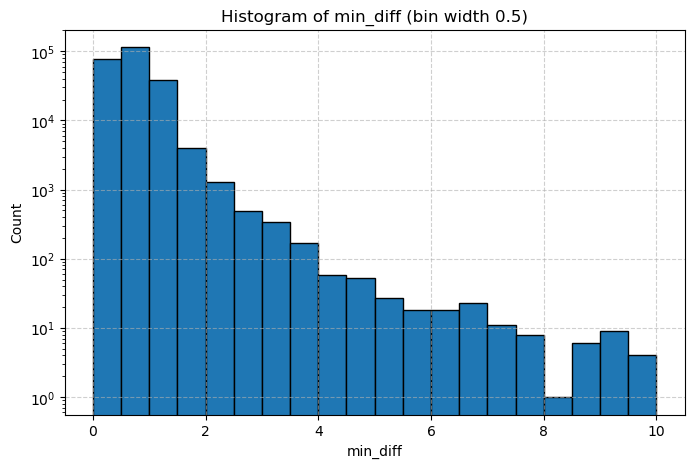

Number of deleted rows:  1026
Number of remaining rows:  236719


In [318]:
# Cleanup noise
every_throw_withpos_clean = every_throw_withpos
# Doing .groupby(["game_str","play_id","event_code"]) makes it only look at
#   the block with the same game_str, play_id, event_code
every_throw_withpos_clean['speed_above'] = every_throw_withpos_clean.groupby(
    ["game_str","play_id","event_code"])['prev_interval_ballspeed'].shift(1)
every_throw_withpos_clean['speed_below'] = every_throw_withpos_clean.groupby(
    ["game_str","play_id","event_code"])['prev_interval_ballspeed'].shift(-1)
every_throw_withpos_clean['diff_above'] = abs(every_throw_withpos_clean['speed_above'] - every_throw_withpos_clean['prev_interval_ballspeed'])
every_throw_withpos_clean['diff_below'] = abs(every_throw_withpos_clean['speed_below'] - every_throw_withpos_clean['prev_interval_ballspeed'])
every_throw_withpos_clean['min_diff'] = np.minimum(every_throw_withpos_clean['diff_above'], every_throw_withpos_clean['diff_below'])

# We're gonna get rid of all rows where its prev_interval_ballspeed value is 
#   more than ??? ft/s off compared to the row above & below

# Use a histogram to determine the ???
bins = np.arange(0, 10 + 0.5, 0.5)
plt.figure(figsize=(8, 5))
n, bins, patches = plt.hist(every_throw_withpos['min_diff'], bins=bins, edgecolor='black')
plt.title('Histogram of min_diff (bin width 0.5)')
plt.xlabel('min_diff')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.yscale('log')  # log scale
plt.show()

# DECISION: 3.0 ft/s
display_df = every_throw_withpos_clean.copy()  # For display
display_df['delete'] = ((display_df['min_diff'] > 3.0))
deleted_rows = every_throw_withpos_clean[(display_df['min_diff'] > 3.0)]
# Keep row if min_diff <= 3.0 ft/s 
every_throw_withpos_clean = every_throw_withpos_clean[(display_df['min_diff'] <= 3.0)]
print(f"Number of deleted rows:  {len(deleted_rows)}")
print(f"Number of remaining rows:  {len(every_throw_withpos_clean)}")

# Drop used columns
every_throw_withpos_clean = every_throw_withpos_clean.drop(
    columns=["speed_above","speed_below","diff_above","diff_below"])
display_df = display_df[["game_str","play_id","player_position","event_code","timestamp","ball_pos_x_adj","ball_pos_y_adj","ball_pos_z_adj","ball_distance","prev_interval_ballspeed","min_diff","delete"]]

# # Display
# HTML(display_df.head(200)
#         .to_html(max_rows=200)
#         .replace('<table', '<div style="height:500px;overflow:auto;"><table')
#         .replace('</table>', '</table></div>'))

In [319]:
"""
Estimate max.velocities (i.e. "the" velo) of each throw
"""
every_throw_clean = every_throw_withpos_clean.groupby(["game_str","play_id","event_code","player_position","thrower_id"])["prev_interval_ballspeed"].max().reset_index()
every_throw_clean = every_throw_clean.rename(columns={"prev_interval_ballspeed":"throw_speed"})

# Convert the speeds to mph
every_throw_clean['throw_mph'] = every_throw_clean['throw_speed'] * 0.681818

# Merge transition_times
every_throw_clean = pd.merge(every_throw_clean, transition_times, how="left", on=["game_str","play_id","player_position"])

every_throw_clean.head(5)

,game_str,play_id,event_code,player_position,thrower_id,throw_speed,throw_mph,transition_ms
0,y1_d001_CGA_QEA,2,3,9,QEA-0252,85.119268,58.035849,2350
1,y1_d001_CGA_QEA,4,3,7,QEA-0249,72.470202,49.411488,1600
2,y1_d001_CGA_QEA,17,3,6,QEA-0027,109.382759,74.579134,850
3,y1_d001_CGA_QEA,21,3,4,QEA-0365,95.411919,65.053564,650
4,y1_d001_CGA_QEA,21,3,5,QEA-0180,92.977075,63.393443,700


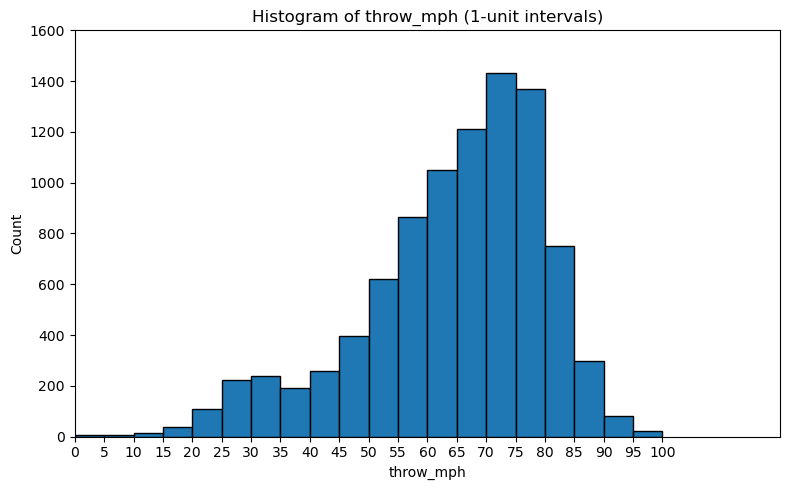

In [320]:
data = every_throw_clean['throw_mph'].dropna()

min_A = np.floor(data.min())
max_A = np.ceil(data.max())
bins = np.arange(min_A, max_A + 1, 5)

plt.figure(figsize=(8, 5))
plt.hist(data, bins=bins, edgecolor='black')
plt.xlabel('throw_mph')
plt.ylabel('Count')
plt.title('Histogram of throw_mph (1-unit intervals)')
plt.xticks(bins)
plt.xlim(0, 120)
plt.ylim(0, 1600)
plt.tight_layout()
plt.show()

In [321]:
"""
Make some charts
"""
def mode_func(x):
    # Return most common value; if tie, returns the first encountered
    return x.mode().iat[0] if not x.mode().empty else None

charting_df = every_throw_clean.groupby('thrower_id').agg(
    main_pos=('player_position', mode_func),
    max_mph=('throw_mph','max'),
    perc95_mph=('throw_mph', lambda x: x.quantile(0.95)),
    mode_mph=('throw_mph', mode_func),
    mode_transition_ms=('transition_ms', mode_func),
    count=('throw_mph', 'size')).reset_index() 

# Rename main position
conditions = [
    charting_df['main_pos'] == 1,    charting_df['main_pos'] == 2,    charting_df['main_pos'] == 3,    charting_df['main_pos'] == 4,
    charting_df['main_pos'] == 5,    charting_df['main_pos'] == 6,    charting_df['main_pos'] == 7,    charting_df['main_pos'] == 8,    charting_df['main_pos'] == 9
]
choices = [
    'pitcher','catcher','first_base','second_base','third_base','shortstop',
    'left_field','center_field','right_field'
]
charting_df['main_pos'] = np.select(conditions, choices, default=None)

# Sort
charting_df = charting_df.sort_values(by='perc95_mph', ascending=False).reset_index(drop=True)
HTML(charting_df.head(100)
        .to_html(max_rows=100)
        .replace('<table', '<div style="height:500px;overflow:auto;"><table')
        .replace('</table>', '</table></div>'))

,thrower_id,main_pos,max_mph,perc95_mph,mode_mph,mode_transition_ms,count
0,JZK-1356,right_field,99.484431,98.166631,54.364271,1050,7
1,UPU-2318,left_field,99.20155,97.541176,65.994074,1350,2
2,XAX-2387,left_field,98.99656,96.670006,47.925616,1050,8
3,YUH-1918,right_field,96.552787,96.461831,46.240184,900,7
4,HCI-2523,left_field,96.092801,95.725194,55.103765,850,8
5,AKX-1254,center_field,103.152902,95.141511,54.101354,900,9
6,APZ-2380,right_field,96.131734,95.07976,33.7536,1500,10
7,DYE-0089,center_field,97.583124,94.745988,26.192852,950,30
8,UPU-1731,right_field,98.081079,94.609009,47.344651,1050,10
9,NYA-2485,center_field,99.803706,93.453759,30.298074,1150,7


In [322]:
# Visualize better
(
    # Convert to a great-table
    gt.GT(charting_df.head(20))
    # Title/Subtitle
    .tab_header(title = "Top 20 Arms")
    # Format columns to a certain number of decimal points
    .fmt_number(columns = ["max_mph", "perc95_mph", "count"], decimals = 1)
    .fmt_number(columns = ["count"], decimals=0)
    # Rename columns for the table
    .cols_label(
        thrower_id = "thrower_id",
        max_mph = "Max velo (mph)",
        perc95_mph = "95th percentile",
        count = "Count"
    )
    # Align all columns to center
    .cols_align("center")
    # Color rows with outfielders
    .tab_style(
    # How to style the cells
    style = gt.style.fill(color="#092C5C"),
    # Which cells to style
    locations = gt.loc.body(columns = "main_pos",
                           rows = [0,1,3,4,6,8,9,10,11,13,14,15,16,18,19])
    )
    # Make text color white for outfielders
    .tab_style(
    # How to style the cells
    style = gt.style.text(color="white"),
    # Which cells to style
    locations = gt.loc.body(columns = "main_pos",
                           rows = [0,1,3,4,6,8,9,10,11,13,14,15,16,18,19])
    )
    # Color rows with infielders
    .tab_style(
    style = gt.style.fill(color="#8FBCE6"),
    locations = gt.loc.body(columns = "main_pos",
                           rows = [2])
    )
    # Color Rows with others
    .tab_style(
    style = gt.style.fill(color="#F5D130"),
    locations = gt.loc.body(columns = "main_pos",
                           rows = [5,7,12,17])
    )
    # # To save the table
    # .save("Top-20-Arms.png")
)

GT(_tbl_data=   thrower_id      main_pos     max_mph  perc95_mph   mode_mph  \
0    JZK-1356   right_field   99.484431   98.166631  54.364271   
1    UPU-2318    left_field    99.20155   97.541176  65.994074   
2    XAX-2387    left_field    98.99656   96.670006  47.925616   
3    YUH-1918   right_field   96.552787   96.461831  46.240184   
4    HCI-2523    left_field   96.092801   95.725194  55.103765   
5    AKX-1254  center_field  103.152902   95.141511  54.101354   
6    APZ-2380   right_field   96.131734    95.07976    33.7536   
7    DYE-0089  center_field   97.583124   94.745988  26.192852   
8    UPU-1731   right_field   98.081079   94.609009  47.344651   
9    NYA-2485  center_field   99.803706   93.453759  30.298074   
10   IKJ-2099   right_field   94.283567   92.988072  30.490733   
11   JIL-1994  center_field   95.778971   92.966186  42.866847   
12   IAQ-1358   right_field   94.515823    92.73163  62.484201   
13   RZQ-0346   right_field  100.451924   92.133117   42.27294   
14   WMI-2030   right_field   95.040775   91.690556  57.683463   
15   VZE-2173     shortstop   92.012081    91.60344   4.737664   
16   JIL-1171    left_field   91.986571   91.329223  70.250108   
17   YJD-0327    left_field   98.309595   91.278654  16.858908   
18   JIL-1986   right_field   93.166529    91.16128  58.022367   
19   KQQ-1320    left_field   92.476158   91.108967  50.856574   

    mode_transition_ms  count  
0                 1050      7  
1                 1350      2  
2                 1050      8  
3                  900      7  
4                  850      8  
5                  900      9  
6                 1500     10  
7                  950     30  
8                 1050     10  
9                 1150      7  
10                1050     12  
11                1550     15  
12                 990      7  
13                1100     95  
14                1200      8  
15                 350      3  
16                 600      3  
17                1300     87  
18                 650      3  
19                 800      8  , _body=<great_tables._gt_data.Body object at 0x0000013D996EDA00>, _boxhead=Boxhead([ColInfo(var='thrower_id', type=<ColInfoTypeEnum.default: 1>, column_label='thrower_id', column_align='center', column_width=None), ColInfo(var='main_pos', type=<ColInfoTypeEnum.default: 1>, column_label='main_pos', column_align='center', column_width=None), ColInfo(var='max_mph', type=<ColInfoTypeEnum.default: 1>, column_label='Max velo (mph)', column_align='center', column_width=None), ColInfo(var='perc95_mph', type=<ColInfoTypeEnum.default: 1>, column_label='95th percentile', column_align='center', column_width=None), ColInfo(var='mode_mph', type=<ColInfoTypeEnum.default: 1>, column_label='mode_mph', column_align='center', column_width=None), ColInfo(var='mode_transition_ms', type=<ColInfoTypeEnum.default: 1>, column_label='mode_transition_ms', column_align='center', column_width=None), ColInfo(var='count', type=<ColInfoTypeEnum.default: 1>, column_label='Count', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000013DA3065E50>, _spanners=Spanners([]), _heading=Heading(title='Top 20 Arms', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='main_pos', rows=[0, 1, 3, 4, 6, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19], mask=None), grpname=None, colname='main_pos', rownum=0, colnum=None, styles=[CellStyleFill(color='#092C5C')]), StyleInfo(locname=LocBody(columns='main_pos', rows=[0, 1, 3, 4, 6, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19], mask=None), grpname=None, colname='main_pos', rownum=1, colnum=None, styles=[CellStyleFill(color='#092C5C')]), StyleInfo(locname=LocBody(columns='main_pos', rows=[0, 1, 3, 4, 6, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19], mask=None), grpname=None, colname='main_pos', rownum=3, colnum=None, styles=[CellStyleFill(color='#092C5C')]), StyleInfo(locname=LocBody(columns='main_pos', rows=[0